# Brain Segmentation with GMM

This jupyter notebook will guide you on how to segment a 3D MRI image in different classes (eg: WM; GM; CSF) using a Gaussian Mixture Model (GMM). For a theoretical description of the model, see the corresponding [blog post](http://www.stefanocerri.com/gaussian-mixture-model-for-brain-mri-segmentation/).

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm

Here we load our image (and the brain mask, if any). I used a generated image from [BrainWeb](https://brainweb.bic.mni.mcgill.ca/), that I then skull-stripped with [deepbrain](https://pypi.org/project/deepbrain/).
For not dealing with voxels that have unwanted values, we remove the voxels that have intensity > minIntensity. You can also add noise to the image and see if the GMM can handle that.

In [2]:
addNoise = False
mask = True
dataFile = '../Data/brain.nii.gz'
# Mask file, if any
maskFile = '../Data/brain_mask.nii'
brainImage = nib.load(dataFile).get_fdata()
minIntensity = 100

if addNoise:
    brainImage = brainImage + np.random.uniform(0, 150, brainImage.shape)
if mask:
    maskIndices = np.logical_and(np.array(nib.load(maskFile).get_data(), dtype=np.bool), brainImage > minIntensity)
    brainIntensities = brainImage[maskIndices]
else:
    maskIndices = brainImage > minIntensity
    brainIntensities = brainImage[brainImage > minIntensity]

Let's visualize the data here. You can play with the value of the array slices to see the different slices in axial, coronal and sagittal view.

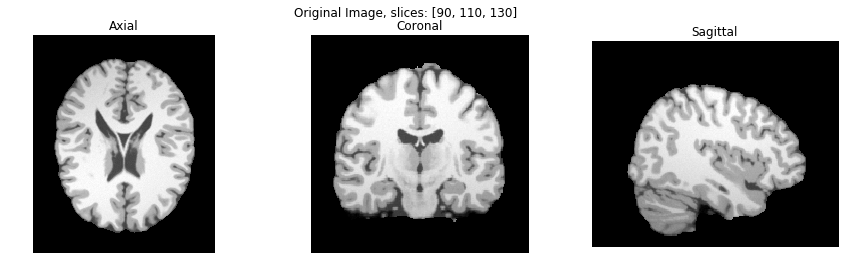

In [3]:
slices = [90, 110, 130]
def plotOriginalImage(slices):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4),)
    fig.suptitle('Original Image, slices: ' + str(slices) )
    ax1.imshow(brainImage[slices[0], :, :], cmap='gray')
    ax1.axis('off')
    ax1.set_title('Axial')
    ax2.imshow(brainImage[::-1,slices[1],::-1], cmap='gray')
    ax2.axis('off')
    ax2.set_title('Coronal')
    ax3.imshow(brainImage[::-1,:,slices[2]], cmap='gray')
    ax3.axis('off')
    ax3.set_title('Sagittal')
    plt.show()

plotOriginalImage(slices)

We are now going to plot the image histogram to see if we can see some intensities peaks that will be fitted by our Gaussian Mixture Model.

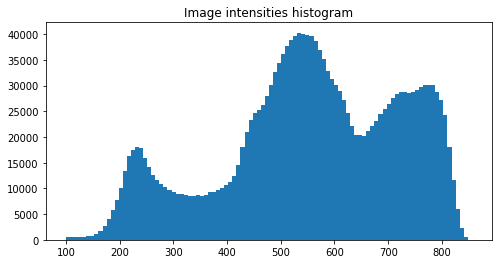

In [4]:
plt.figure(figsize=(8, 4))
_ = plt.hist(brainIntensities.ravel(), bins=100) 
plt.title("Image intensities histogram")
plt.show()

Now let's create our GMM model. We are goint to initialize the mean and variances with plausible values. Feel free to change the number of components to see how the results change.

In [5]:
# Here you can define the number of components of the GMM
nComponents = 3

# Let's create the GMM parameters
GMM_means = np.zeros([nComponents, 1])
GMM_variances = np.zeros([nComponents, 1])
GMM_weights = np.zeros([nComponents])

# initialization: 
# -values of the means: every range/nClasses
# -values of the variances: 2*initialWidth
# -values of the weights: 1/nClasses
minIntensity = brainIntensities.min()
maxIntensity = brainIntensities.max()
initialWidth = (maxIntensity - minIntensity) / nComponents

for n in range(nComponents):
    GMM_means[n] = minIntensity + (n + 1) * (initialWidth)
    GMM_variances[n] = initialWidth**2
    GMM_weights[n] = 1/nComponents

Let's now super-impose our GMM on top of the histogram.

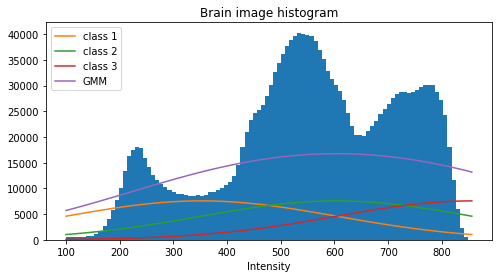

In [6]:
bins = 100

def plotHistWithGMM(bins=100):
    plt.figure(figsize=(8, 4))
    val, binsH, _ = plt.hist(brainIntensities.ravel(), bins=bins) 
    area =  sum(np.diff(binsH)*val)
    plt.title("Brain image histogram")
    x = np.linspace(minIntensity, maxIntensity, bins)
    gmmNorm = np.zeros(x.shape)
    for n in range(nComponents):
        plt.plot(x, area * GMM_weights[n] * norm.pdf(x, GMM_means[n], np.sqrt(GMM_variances[n])), label='class ' + str(n + 1))
        gmmNorm +=  area * GMM_weights[n] * norm.pdf(x, GMM_means[n], np.sqrt(GMM_variances[n]))
    plt.plot(x, gmmNorm, label='GMM')
    plt.xlabel('Frequency')
    plt.xlabel('Intensity')
    plt.legend()
    plt.show()
    
plotHistWithGMM(bins)

Note that our GMM is far from fitting the data.
We can now start with the EM algorithm and see how well we can fit the data with our GMM model as well as plot our segmentation maps of our segmented brain structures.

Let's compute the initial segmentation (computing the posterior distribution and take the maximum argument) with this parameter initialization and show them. Here you can set up a flag if you want to see also the "soft" segmentation for each component.

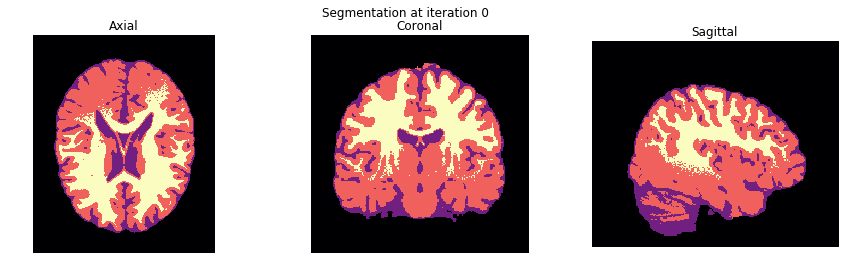

In [7]:
# Flag for soft segmentation visual
softPlots = False

# Compute posteriors
posteriors = np.zeros([len(brainIntensities), nComponents])
for n in range(nComponents):
    posteriors[:, n] = GMM_weights[n] * norm.pdf(brainIntensities, GMM_means[n], np.sqrt(GMM_variances[n]))
# Normalize them
eps = np.finfo(float).eps
normalizer = np.sum(posteriors, axis=1)
posteriors = posteriors / (normalizer[:, np.newaxis] + eps)
hardSegmentation = np.argmax(posteriors, axis=1)

def plotSoftPosterior(slices=[60, 50, 40]):
    for n in range(nComponents):
        tmp = np.zeros(brainImage.shape)
        tmp[maskIndices] = posteriors[:, n]
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
        fig.suptitle('Class: ' + str(n+1) )
        ax1.imshow(tmp[slices[0], :, :], cmap='gray')
        ax1.axis('off')
        ax1.set_title('Axial')
        ax2.imshow(tmp[::-1,slices[1],::-1], cmap='gray')
        ax2.axis('off')
        ax2.set_title('Coronal')
        ax3.imshow(tmp[::-1,:,slices[2]], cmap='gray')
        ax3.axis('off')
        ax3.set_title('Sagittal')
        plt.show()
        
def plotHardPosterior(slices=[60, 50, 40], it=0):
    tmp = np.zeros(brainImage.shape)
    tmp[maskIndices] = hardSegmentation + 1
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    fig.suptitle('Segmentation at iteration ' + str(it))
    ax1.imshow(tmp[slices[0], :, :], cmap='magma')
    ax1.axis('off')
    ax1.set_title('Axial')
    ax2.imshow(tmp[::-1,slices[1],::-1], cmap='magma')
    ax2.axis('off')
    ax2.set_title('Coronal')
    ax3.imshow(tmp[::-1,:,slices[2]], cmap='magma')
    ax3.axis('off')
    ax3.set_title('Sagittal')
    plt.show()
        
# Show initial segmentation
if softPlots:
    plotSoftPosterior(slices)
plotHardPosterior(slices)

Note that even if we have a poor parameter initialization, we can start seeing some sort of brain segmentation. Note how the background and CSF ended up in the same class right now.

Let's run the EM algorithm for some iterations and see how the segmentation change. A more robust implementation would look at the log-likelihood (guaranteed to increase at each iteration) and set a minimum increase threshold.

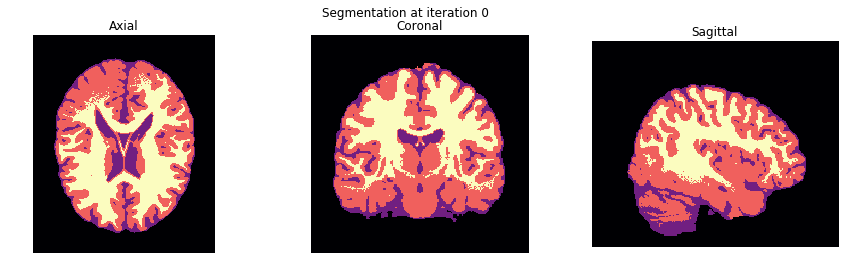

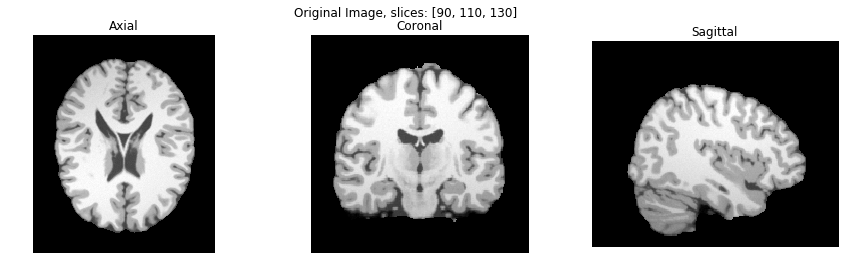

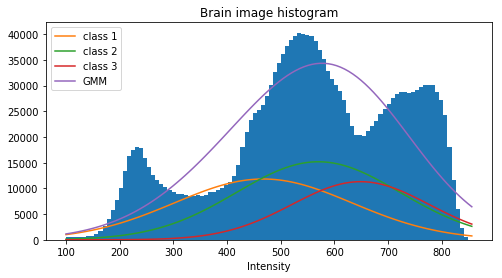

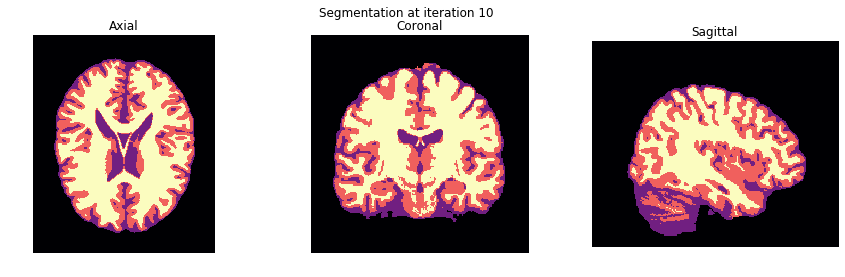

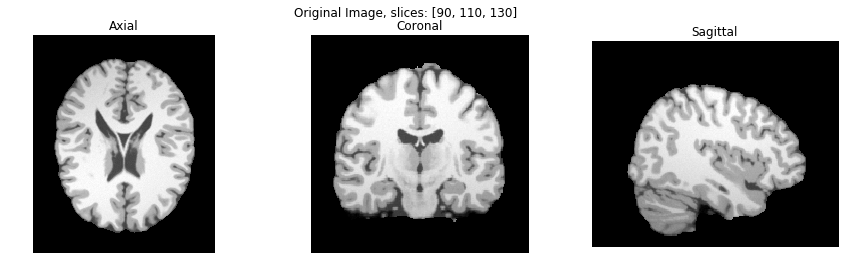

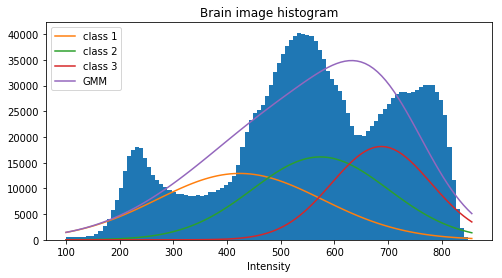

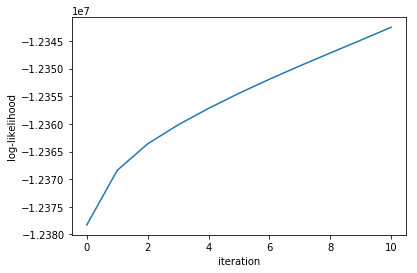

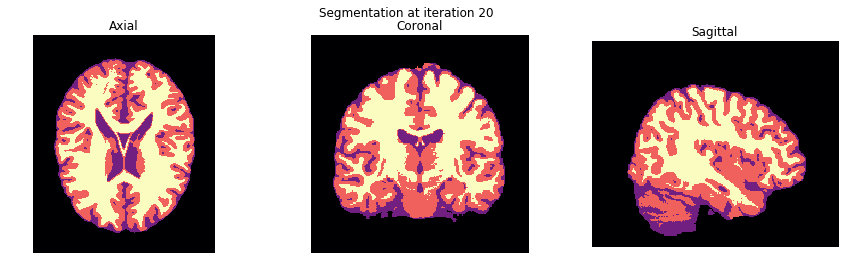

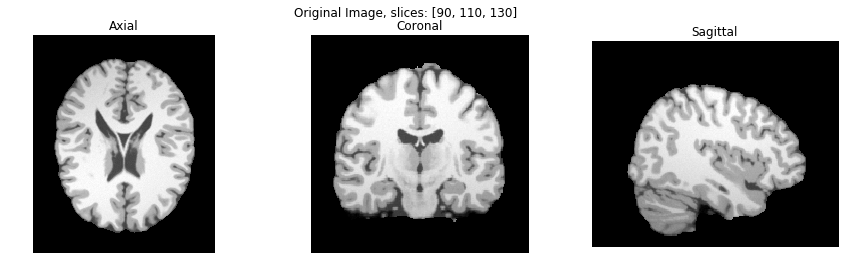

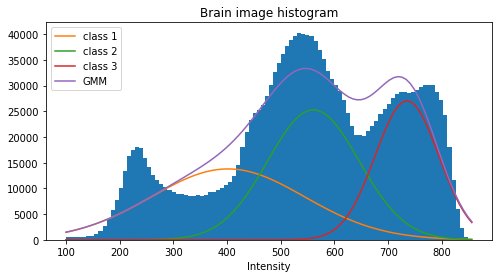

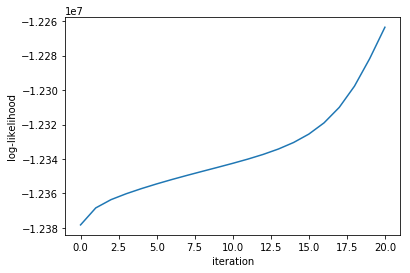

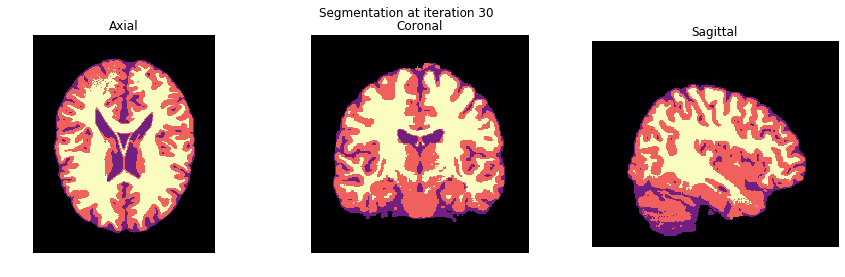

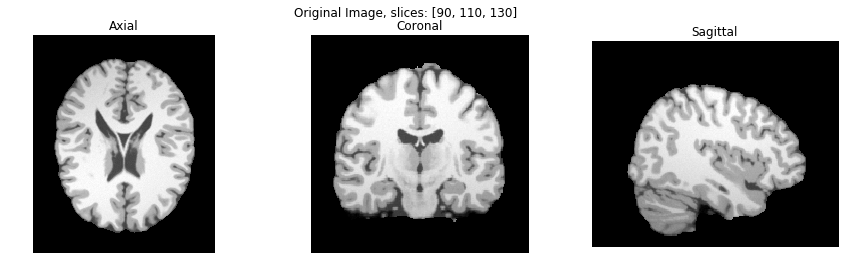

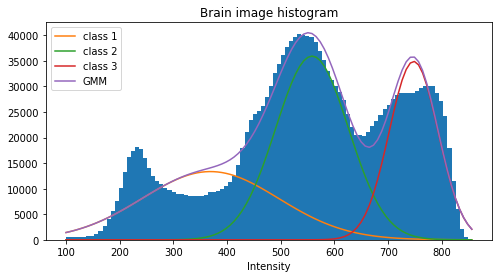

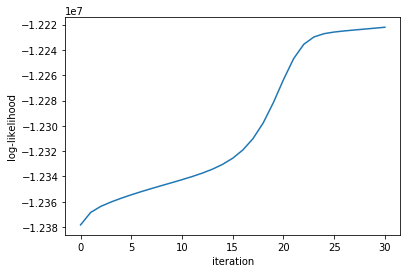

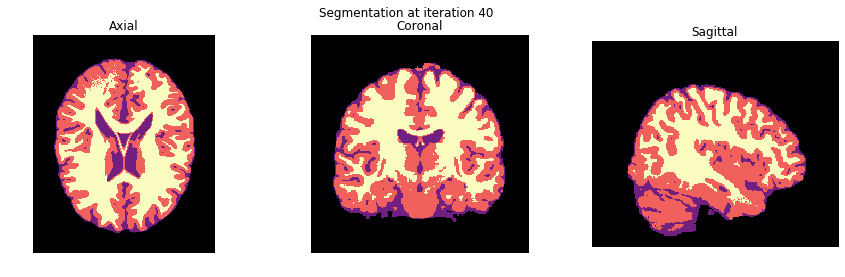

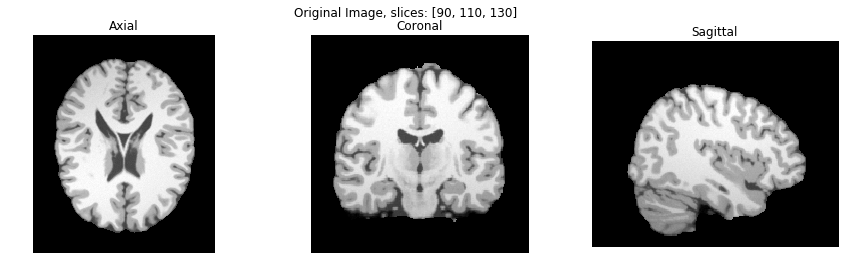

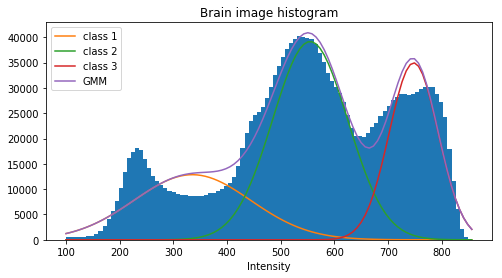

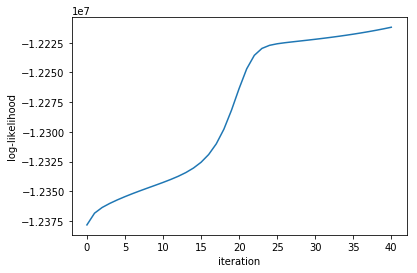

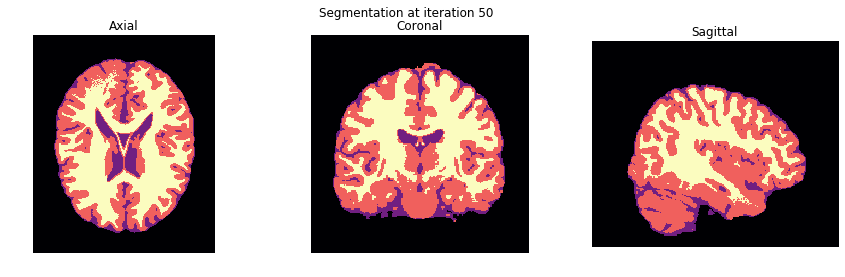

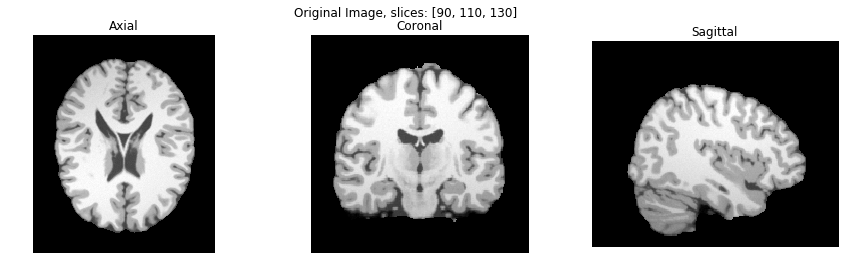

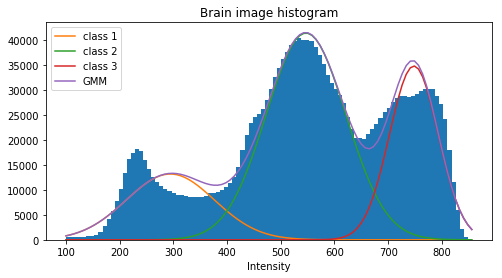

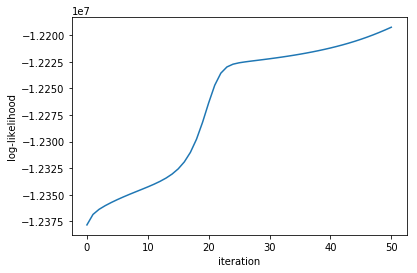

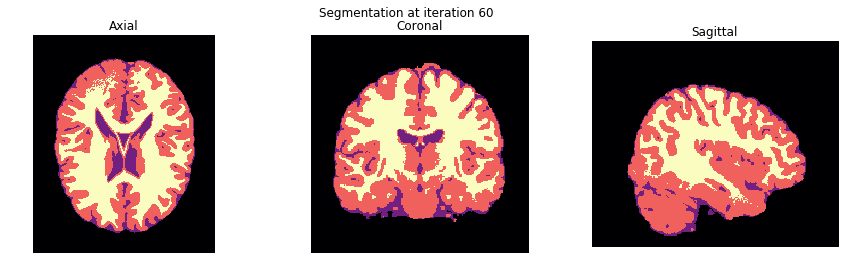

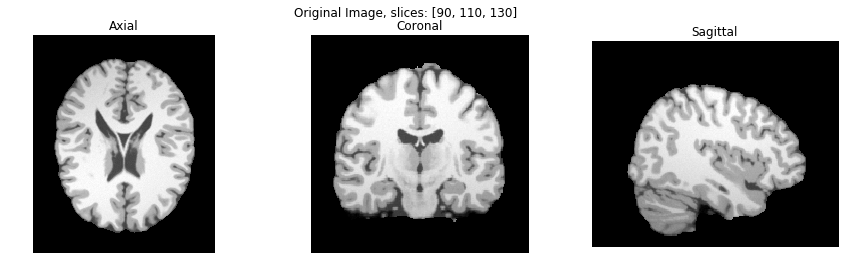

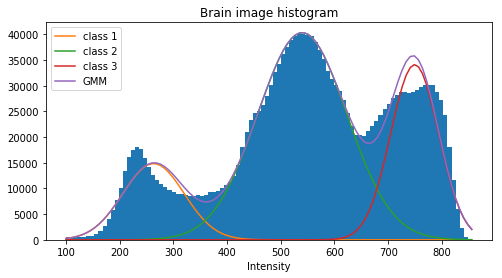

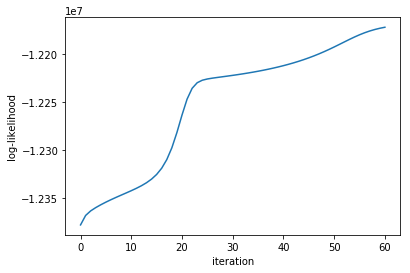

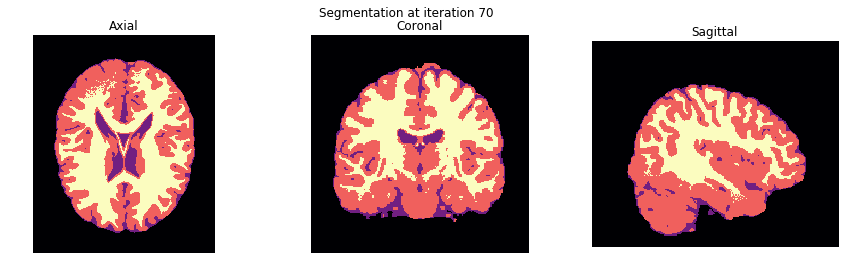

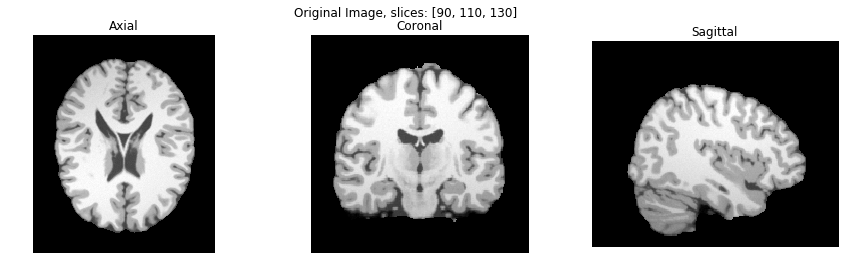

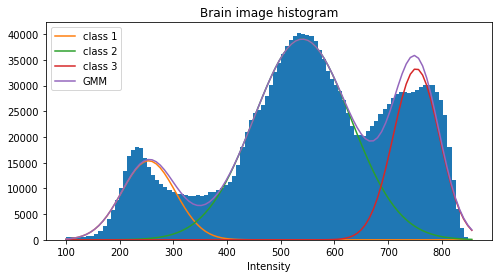

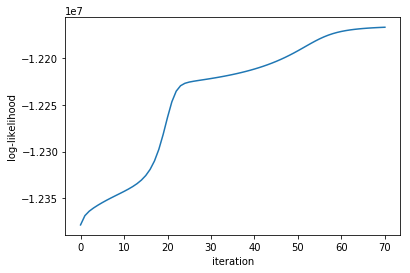

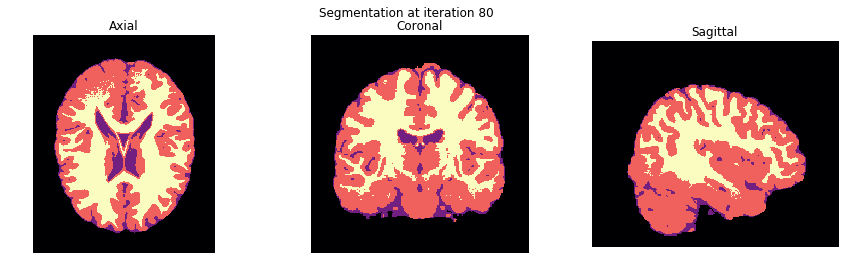

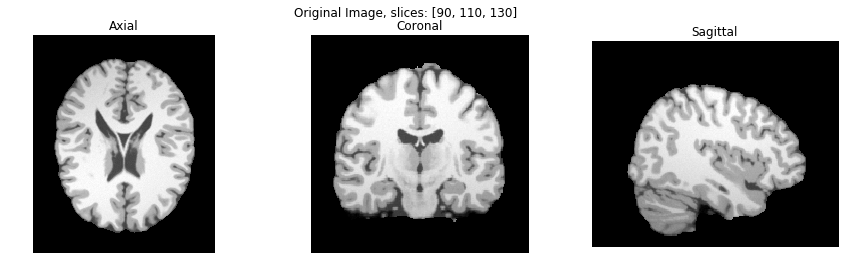

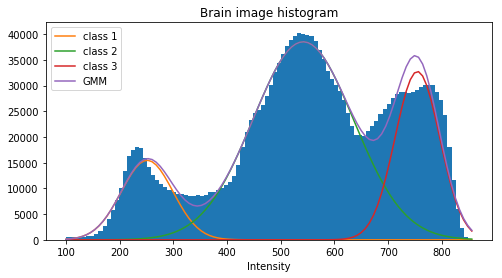

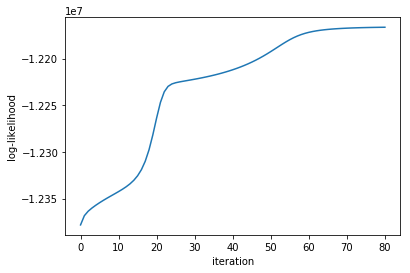

In [8]:
def plotLikelihood(likelihoodHistory):
    if len(likelihoodHistory) > 1:
        plt.plot(likelihoodHistory)
        plt.show
        plt.xlabel('iteration')
        plt.ylabel('log-likelihood')

maxIteration = 80
showEveryX = 10
likelihoodHistory = []
# Start EM
it = 0
stopCondition = False
minDifference = 1e-4

while(it < maxIteration + 1 and not stopCondition):
    # Update parameters based on the current classification
    for n in range(nComponents):
        softSum = np.sum(posteriors[:, n])
        GMM_means[n] = (posteriors[:, n].T @ brainIntensities) / (softSum)
        GMM_variances[n] = (posteriors[:, n].T @ (brainIntensities - GMM_means[n])**2) / (softSum)
        GMM_weights[n] = softSum / len(brainIntensities)
        
    # Update classification based on the current parameters
    for n in range(nComponents):
        posteriors[:, n] = GMM_weights[n] * norm.pdf(brainIntensities, GMM_means[n], np.sqrt(GMM_variances[n]))
    
    # Compute likelihood
    likelihoodHistory.append(np.sum(np.log(np.sum(posteriors, axis=1))))
    
    # Normalize posterior
    eps = np.finfo(float).eps
    normalizer = np.sum(posteriors, axis=1)
    posteriors = posteriors / (normalizer[:, np.newaxis] + eps)

    if it % (showEveryX ) == 0:
        if softPlots:
            plotSoftPosterior(slices)
        hardSegmentation = np.argmax(posteriors, axis=1)
        plotHardPosterior(slices, it)
        plotOriginalImage(slices)
        plotHistWithGMM(bins)
        plotLikelihood(likelihoodHistory)

    if it > 1 and np.abs(likelihoodHistory[-1] - likelihoodHistory[-2]) < minDifference:
        print("Algorithm converges since cost per iteration is smaller than minDifference")
        stopCondition = True
    
    it = it + 1


The algorithm converged. Let's show our final result!

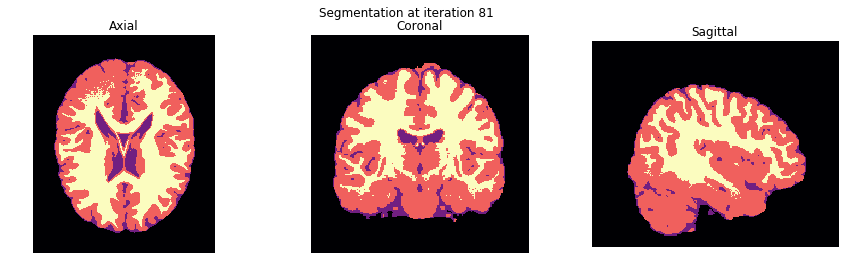

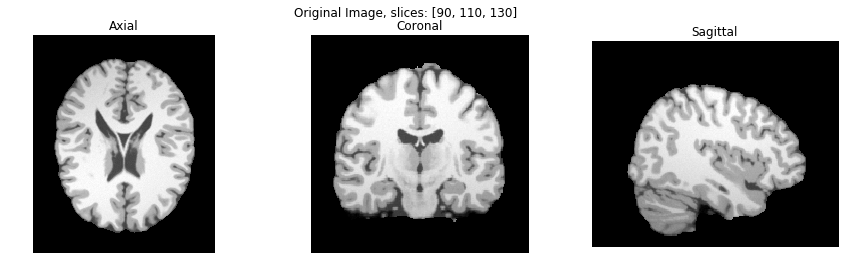

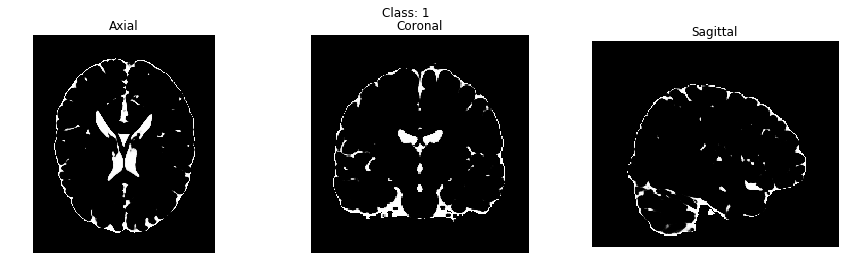

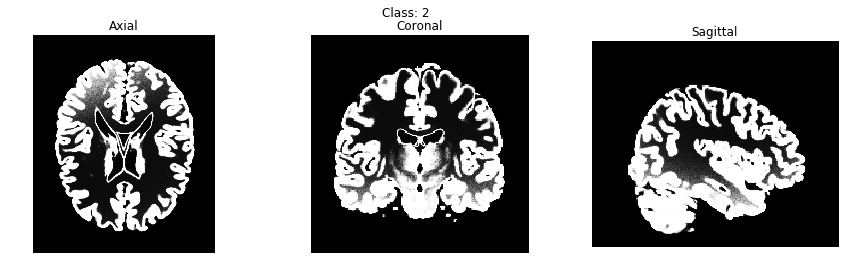

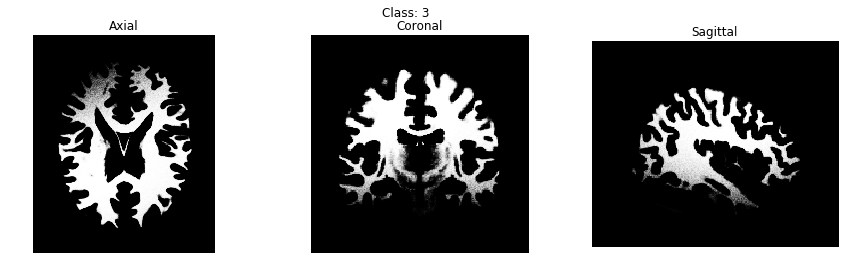

In [9]:
softPlots = True
plotHardPosterior(slices, it)
plotOriginalImage(slices)
if softPlots:
    plotSoftPosterior(slices)

Let's save the result to file.

In [10]:
# Segmentation file name
imageFileName = 'seg' 
# Output path
imagePath = '.'

hardSegmentation = np.argmax(posteriors, axis=1)
tmp = np.zeros(brainImage.shape)
tmp[maskIndices] = hardSegmentation
# Load the affine transformation of the input data, so that the segmentation is in the same space
affine = nib.load(dataFile).affine
# Save image
img = nib.Nifti1Image(tmp, affine)
nib.save(img, os.path.join(imagePath, imageFileName))